In [2]:
import hyperopt as hyperopt
import numpy as np
import pandas
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing.setup import configuration
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, robust_scale, quantile_transform

In [92]:
data = pd.read_csv('hotel_bookings.csv')
data.head()

C:\Users\fight\AppData\Local\Temp\ipykernel_58164\3678562391.py:1: DtypeWarning: Columns (34,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('hotel_bookings.csv').drop(columns = ['Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38'])


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/7/2015


In [96]:
data.isna().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
hotel                                  0
previous_cancellations                 0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
previous_bookings_not_canceled         0
is_repeated_guest                      0
is_canceled                            0
distribution_channel                   0
market_segment                         0
meal                                   0
babies                                 0
adults                                 0
stays_in_week_ni

In [97]:
data[data.children.isnull()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
40600,City Hotel,1,2,2015,August,32,3,1,0,2,...,No Deposit,NaN,NaN,0,Transient-Party,12.0,0,1,Canceled,1/8/2015
40667,City Hotel,1,1,2015,August,32,5,0,2,2,...,No Deposit,14.0,NaN,0,Transient-Party,12.0,0,1,Canceled,4/8/2015
40679,City Hotel,1,1,2015,August,32,5,0,2,3,...,No Deposit,NaN,NaN,0,Transient-Party,18.0,0,2,Canceled,4/8/2015
41160,City Hotel,1,8,2015,August,33,13,2,5,2,...,No Deposit,9.0,NaN,0,Transient-Party,76.5,0,1,Canceled,9/8/2015


In [98]:
# since this is a low number of bookings, we can replace the values by 0
data.children = data.children.fillna(0)

In [99]:
country_null = data[data.country.isnull()]
country_null.groupby('hotel').count()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
hotel,,,,,,,,,,,,,,,,,,,,,
City Hotel,24,24,24,24,24,24,24,24,24,24,...,24,16,8,24,24,24,24,24,24,24
Resort Hotel,464,464,464,464,464,464,464,464,464,464,...,464,138,166,464,464,464,464,464,464,464


In [100]:
# For missing countries, assign countries based on countries with the highest hotel type frequency
data.groupby('country').hotel.value_counts().sort_values(ascending=False)

country  hotel       
PRT      City Hotel      30960
         Resort Hotel    17630
FRA      City Hotel       8804
GBR      Resort Hotel     6814
DEU      City Hotel       6084
                         ...  
GGY      Resort Hotel        1
SYC      City Hotel          1
PER      Resort Hotel        1
SYR      Resort Hotel        1
SYC      Resort Hotel        1
Name: hotel, Length: 291, dtype: int64

In [101]:
# assign missing countries as Portugal since it has the highest frequency for both
data.country = data.country.fillna('PRT')

In [102]:
# for agents and countries, the null value represents that the booking was made without an agent, or company
# these can be replaced by 0
data[['agent', 'company']] = data[['agent', 'company']].fillna(0)

In [104]:
# check all null values
data.isna().sum().sum()

0

In [148]:
# Now we can move onto assigning variables their correct data_types
cat_list = [col_name for i, col_name in enumerate(data.columns) if data[f'{col_name}'].dtype == 'object'
            or data[f'{col_name}'].dtype == 'category']
cat_list

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'company',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [149]:
# remove the date related terms from this category
cat_list = [i for i in cat_list if not i.__contains__('date')]

In [151]:
data[cat_list] = data[cat_list].astype('category')

In [150]:
# create a list of date columns for date related work
date_list = [col_name for i, col_name in enumerate(data.columns) if col_name.__contains__('date')]
date_list

['arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'reservation_status_date']

In [160]:
time_data = pd.DataFrame(data[date_list])

In [161]:
from datetime import datetime
month_num = lambda x: datetime.strptime(x, '%B').month
time_data.loc[:,'arrival_date_month'] = time_data['arrival_date_month'].map(month_num)
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date
0,2015,7,27,1,1/7/2015
1,2015,7,27,1,1/7/2015
2,2015,7,27,1,2/7/2015
3,2015,7,27,1,2/7/2015
4,2015,7,27,1,3/7/2015


In [164]:
# add in column arrival day for continuous time series by day of year
day_of_year = lambda year, month, day: datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d").timetuple().tm_yday
day_list = []
for i in range(len(time_data)):
    yr = time_data.arrival_date_year[i]
    mth = time_data.arrival_date_month[i]
    dy = time_data.arrival_date_day_of_month[i]
    x = day_of_year(yr, mth, dy)
    day_list.append(x)

time_data['year_day'] = pd.DataFrame(day_list, columns=['year_day'])
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day
0,2015,7,27,1,1/7/2015,182
1,2015,7,27,1,1/7/2015,182
2,2015,7,27,1,2/7/2015,182
3,2015,7,27,1,2/7/2015,182
4,2015,7,27,1,3/7/2015,182


In [170]:
year_format = lambda year, month, day: str(f'{day}/{month}/{year}')
time_data.loc[:,'arrival_date'] = time_data.apply(lambda x: year_format(x['arrival_date_year'], x['arrival_date_month'],
x['arrival_date_day_of_month']), axis=1)
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day,arrival_date
0,2015,7,27,1,1/7/2015,182,1/7/2015
1,2015,7,27,1,1/7/2015,182,1/7/2015
2,2015,7,27,1,2/7/2015,182,1/7/2015
3,2015,7,27,1,2/7/2015,182,1/7/2015
4,2015,7,27,1,3/7/2015,182,1/7/2015


In [178]:
status_change_time = lambda arrival_date, reservation_date: (datetime.strptime(reservation_date, '%d/%m/%Y') -\
                                                            datetime.strptime(arrival_date, '%d/%m/%Y')).days
time_data.loc[:,'change_time'] = time_data.apply(lambda x: status_change_time(x['arrival_date'], x['reservation_status_date']),
                                                 axis=1)
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day,arrival_date,change_time
0,2015,7,27,1,1/7/2015,182,1/7/2015,0
1,2015,7,27,1,1/7/2015,182,1/7/2015,0
2,2015,7,27,1,2/7/2015,182,1/7/2015,1
3,2015,7,27,1,2/7/2015,182,1/7/2015,1
4,2015,7,27,1,3/7/2015,182,1/7/2015,2


In [182]:
# count number of bookings per day and number of cancellations
time_data['arrival_date'] = pd.to_datetime(time_data['arrival_date'], format='%d/%m/%Y')

In [183]:
time_data.groupby('arrival_date').count()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day,change_time
arrival_date,,,,,,,
2015-07-01,122,122,122,122,122,122,122
2015-07-02,93,93,93,93,93,93,93
2015-07-03,56,56,56,56,56,56,56
2015-07-04,88,88,88,88,88,88,88
2015-07-05,53,53,53,53,53,53,53
...,...,...,...,...,...,...,...
2017-08-27,174,174,174,174,174,174,174
2017-08-28,211,211,211,211,211,211,211
2017-08-29,125,125,125,125,125,125,125


In [186]:
time_data = pd.concat([time_data, data['is_canceled']], axis = 1)


In [187]:
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day,arrival_date,change_time,is_canceled
0,2015,7,27,1,1/7/2015,182,2015-07-01,0,0
1,2015,7,27,1,1/7/2015,182,2015-07-01,0,0
2,2015,7,27,1,2/7/2015,182,2015-07-01,1,0
3,2015,7,27,1,2/7/2015,182,2015-07-01,1,0
4,2015,7,27,1,3/7/2015,182,2015-07-01,2,0


In [214]:
time_data.shape

(119390, 9)

In [202]:
time_data_by_day = pd.DataFrame(time_data.groupby('arrival_date')['is_canceled'].sum())

In [217]:
time_data_by_day['total_bookings'] = pd.DataFrame(time_data['arrival_date'].value_counts())
time_data_by_day.head()

,is_canceled,total_bookings
arrival_date,,
2015-07-01,19,122
2015-07-02,57,93
2015-07-03,19,56
2015-07-04,43,88
2015-07-05,16,53


<AxesSubplot:xlabel='arrival_date'>

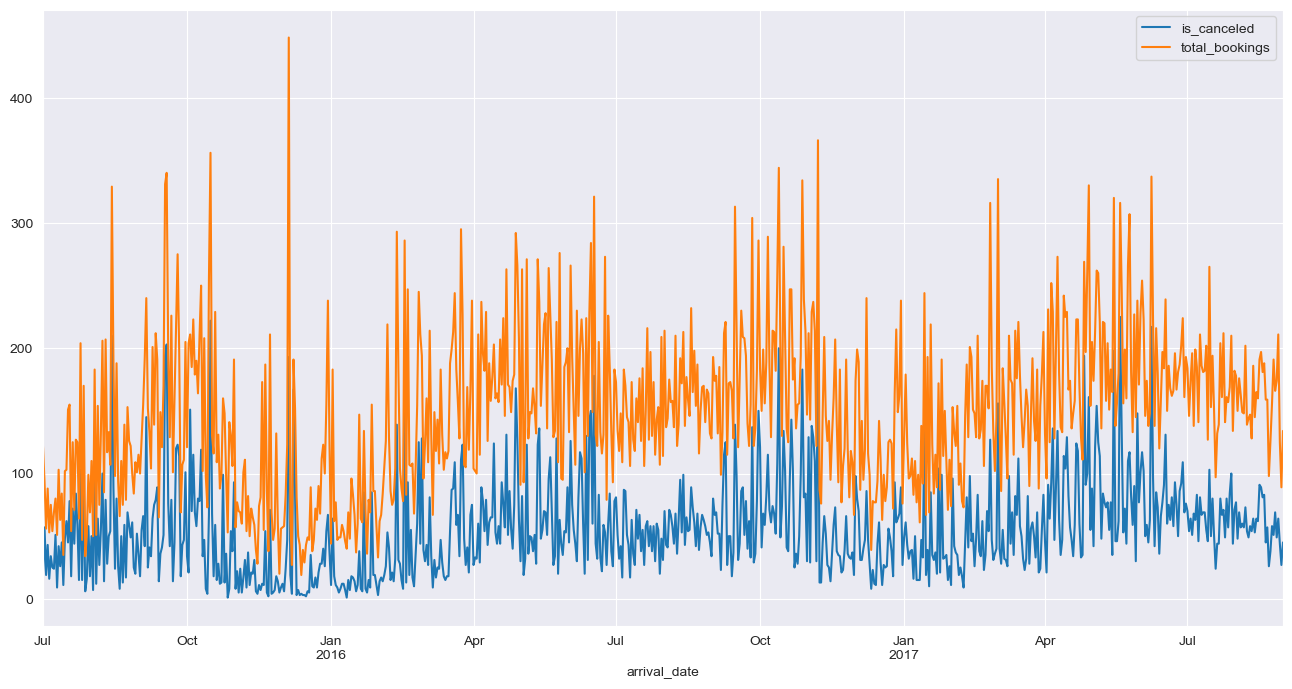

In [220]:
time_data_by_day.plot(figsize = (16, 8))

In [295]:
time_train = pd.DataFrame(time_data_by_day.loc[time_data_by_day.index < '01-01-2017']).drop(index='2015-12-05')
time_test = pd.DataFrame(time_data_by_day.loc[time_data_by_day.index >= '01-01-2017'])

In [296]:
def create_feature(df):
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    return df

In [297]:
time_train = create_feature(time_train)

In [298]:
time_train.head()

,is_canceled,total_bookings,prediction_x,prediction_y,prediction,day_of_month,month,year,day_of_year
arrival_date,,,,,,,,,
2015-07-01,19,122,NaN,NaN,NaN,1,7,2015,182
2015-07-02,57,93,NaN,NaN,NaN,2,7,2015,183
2015-07-03,19,56,NaN,NaN,NaN,3,7,2015,184
2015-07-04,43,88,NaN,NaN,NaN,4,7,2015,185
2015-07-05,16,53,NaN,NaN,NaN,5,7,2015,186


In [299]:
time_test = create_feature(time_test)
time_test.head()

,is_canceled,total_bookings,prediction_x,prediction_y,prediction,day_of_month,month,year,day_of_year
arrival_date,,,,,,,,,
2017-01-01,49,128,33.139904,24.214428,24.214428,1,1,2017,1
2017-01-02,61,179,57.508606,34.190792,34.190792,2,1,2017,2
2017-01-03,43,124,29.383745,19.240950,19.240950,3,1,2017,3
2017-01-04,32,96,20.249779,13.850859,13.850859,4,1,2017,4
2017-01-05,38,98,20.012560,13.850859,13.850859,5,1,2017,5


In [300]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [276]:
features = ['total_bookings', 'day_of_month', 'month', 'year',
            'day_of_year']
target = ['is_canceled']

In [301]:
X_train = time_train[features]
y_train = time_train[target]
X_test = time_test[features]
y_test = time_test[target]

In [302]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = True)

[0]	validation_0-rmse:63.86621	validation_1-rmse:72.93114
[1]	validation_0-rmse:63.29563	validation_1-rmse:72.30348
[2]	validation_0-rmse:62.73106	validation_1-rmse:71.68239
[3]	validation_0-rmse:62.17249	validation_1-rmse:71.06765
[4]	validation_0-rmse:61.61994	validation_1-rmse:70.45002
[5]	validation_0-rmse:61.07308	validation_1-rmse:69.84809
[6]	validation_0-rmse:60.53215	validation_1-rmse:69.24328
[7]	validation_0-rmse:59.99707	validation_1-rmse:68.65722
[8]	validation_0-rmse:59.46763	validation_1-rmse:68.06537
[9]	validation_0-rmse:58.94370	validation_1-rmse:67.48924
[10]	validation_0-rmse:58.42519	validation_1-rmse:66.92859
[11]	validation_0-rmse:57.91237	validation_1-rmse:66.36772
[12]	validation_0-rmse:57.40477	validation_1-rmse:65.81887
[13]	validation_0-rmse:56.90275	validation_1-rmse:65.26285
[14]	validation_0-rmse:56.40618	validation_1-rmse:64.70511
[15]	validation_0-rmse:55.91453	validation_1-rmse:64.17361
[16]	validation_0-rmse:55.42849	validation_1-rmse:63.64348
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [303]:
fi = pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.head()

,importance
total_bookings,0.770025
day_of_month,0.057133
month,0.042136
year,0.068926
day_of_year,0.061780


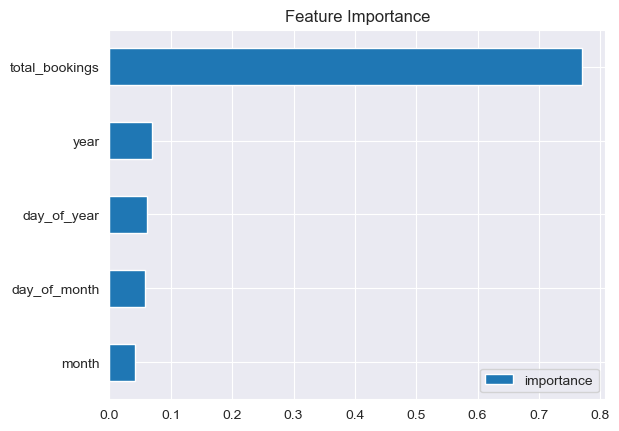

In [304]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [305]:
time_test['prediction'] = reg.predict(X_test)

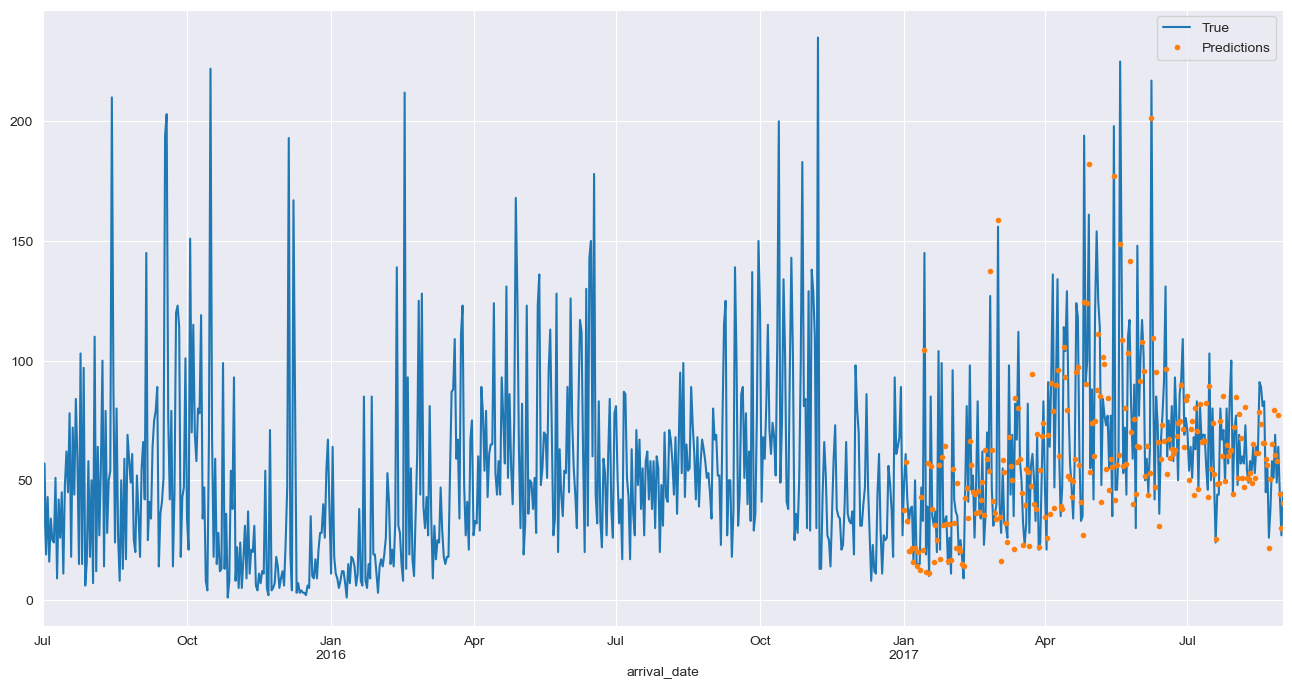

In [307]:
time_data_by_day = time_data_by_day.merge(time_test[['prediction']], how = 'left', left_index=True, right_index=True)
ax = time_data_by_day[['is_canceled']].plot(figsize=(16,8))
time_data_by_day['prediction'].plot(ax = ax, style = '.')
plt.legend(['True', 'Predictions'])
plt.show()

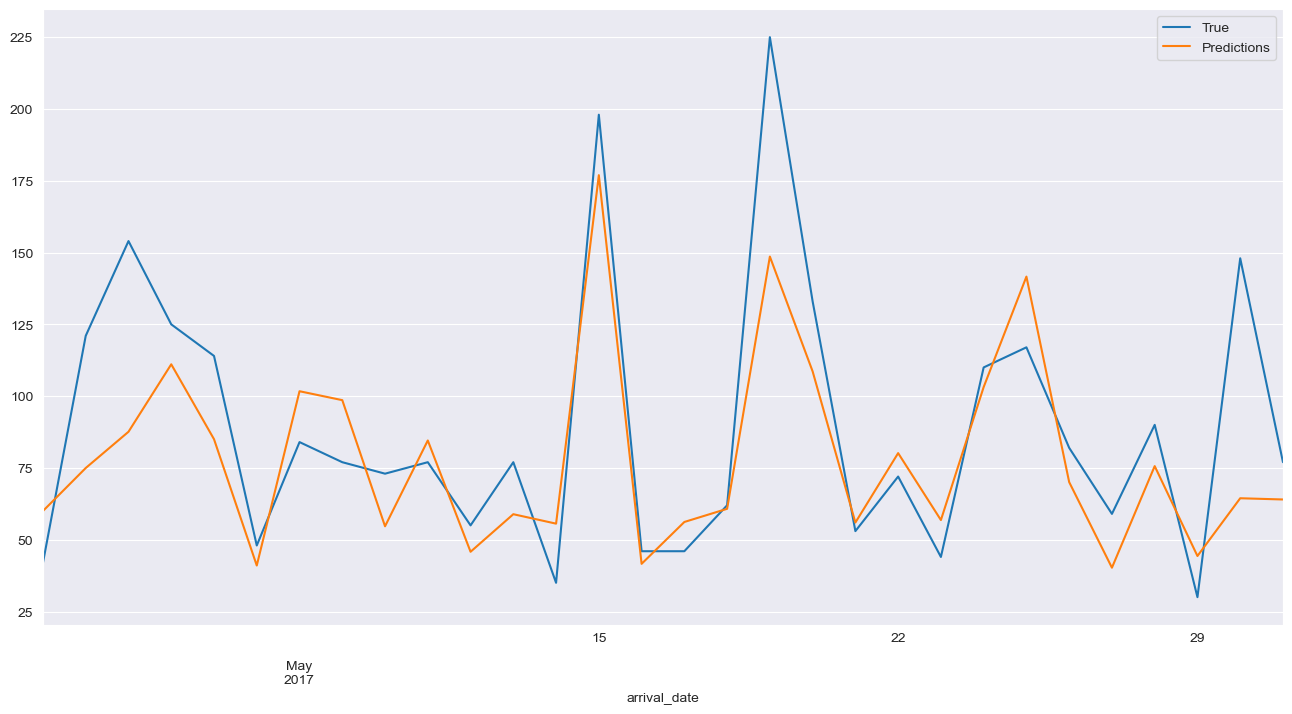

In [308]:
ax = time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['is_canceled']\
    .plot(figsize=(16,8))
time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['prediction'] \
    .plot(ax = ax)
plt.legend(['True', 'Predictions'])
plt.show()

In [309]:
np.sqrt(mean_squared_error(y_test['is_canceled'], reg.predict(X_test)))

18.628657494237796

In [286]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

In [310]:
mape(y_test['is_canceled'], reg.predict(X_test))

0.20877907365338644

In [346]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.metrics import accuracy_score

In [347]:
space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 5, 1)),
         'gamma': hp.uniform ('gamma', 0,1),
         'reg_alpha' : hp.uniform('reg_alpha', 0,50),
         'reg_lambda' : hp.uniform('reg_lambda', 10,100),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
         'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
         'n_estimators': 10000,
         'learning_rate': hp.uniform('learning_rate', 0, .15),
         'tree_method':'gpu_hist',
         'gpu_id': 0,
         'random_state': 5,
         'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}

In [434]:
from sklearn.metrics import log_loss

In [543]:
def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(**space)

    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_test, y_test)]
    evaluation_dart = [(X_test, y_test)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train, eval_set = evaluation_dart, verbose = False)
    #Obtain prediction and log_loss score.
    pred = model.predict(X_test)
    loss = mean_squared_error(y_test, pred,squared=False)
    print ("SCORE:", loss)

    #Specify what the loss is for each model.
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [355]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

SCORE:                                                
17.148134287800648                                    
SCORE:                                                                          
16.838887558978893                                                              
SCORE:                                                                          
17.24291585073091                                                               
SCORE:                                                                          
17.014494741443972                                                              
SCORE:                                                                          
17.521994570947015                                                              
SCORE:                                                                          
16.074582616167724                                                              
SCORE:                                                                          

In [356]:
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
                                       trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8119929829715007, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1580262575196727, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.041737253186350215, max_bin=219,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=0.5863733403943283, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=5, ...)


In [357]:
xgb_preds_best = best_model.predict(X_test)
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

RMSE_Best_Model: 16.074582616167724


In [359]:
mape(y_test['is_canceled'], best_model.predict(X_test))

0.18749864075713657

In [362]:
time_test['prediction_2'] = best_model.predict(X_test)

In [363]:
time_data_by_day = time_data_by_day.merge(time_test[['prediction_2']], how = 'left', left_index=True, right_index=True)

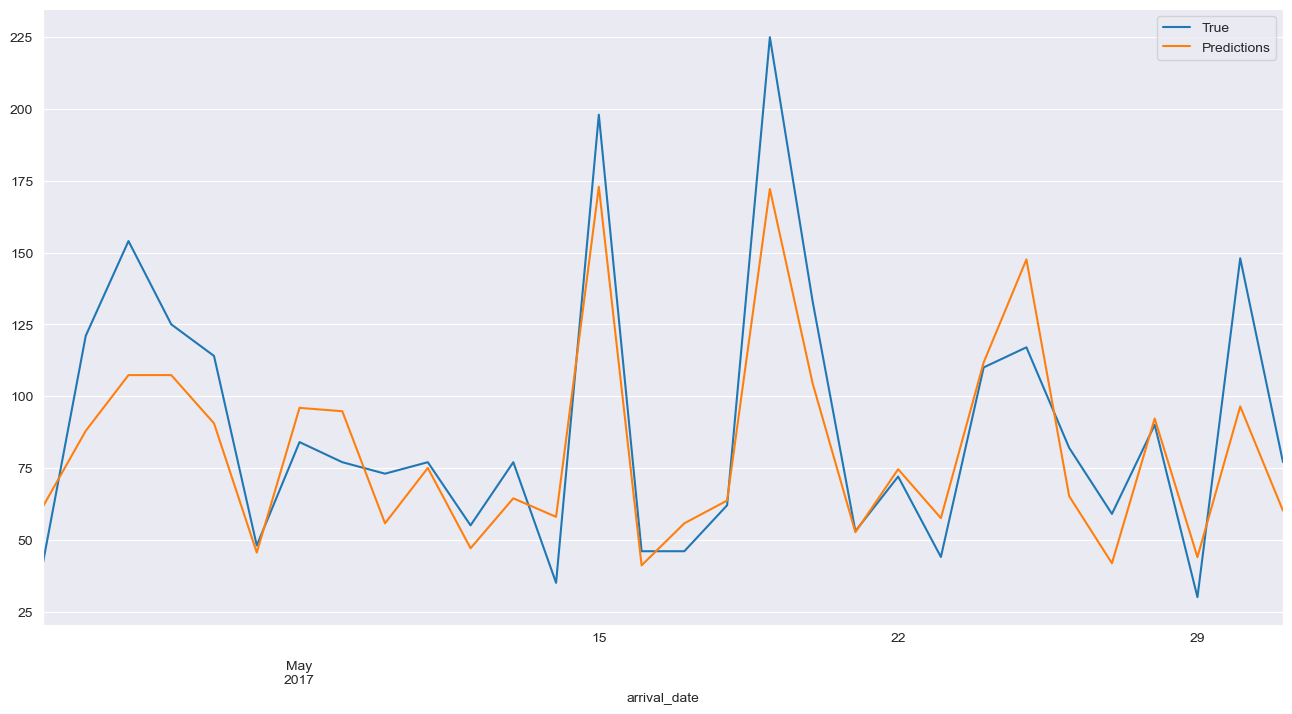

In [364]:
ax = time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['is_canceled'] \
    .plot(figsize=(16,8))
time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['prediction_2'] \
    .plot(ax = ax)
plt.legend(['True', 'Predictions'])
plt.show()

In [365]:
time_data_by_day.tail(10)

,is_canceled,total_bookings,prediction_x,prediction_y,prediction_x,prediction_y,prediction,prediction_2
arrival_date,,,,,,,,
2017-08-22,26,98,21.091583,13.150660,13.150660,21.619556,21.619556,31.745173
2017-08-23,38,126,49.681927,31.945234,31.945234,50.519772,50.519772,46.019417
2017-08-24,58,156,63.955566,36.498795,36.498795,65.155518,65.155518,59.816025
2017-08-25,51,191,79.163895,50.533546,50.533546,79.475487,79.475487,81.411400
2017-08-26,69,166,61.273960,38.789463,38.789463,60.715286,60.715286,64.387283
2017-08-27,49,174,58.387615,39.717648,39.717648,58.000015,58.000015,65.791016
2017-08-28,64,211,78.349747,50.882038,50.882038,77.244736,77.244736,85.196548
2017-08-29,44,125,43.176079,27.438889,27.438889,44.311939,44.311939,43.625767
2017-08-30,27,89,31.207724,17.356865,17.356865,30.165794,30.165794,24.175432


In [403]:
def create_lag(df: pd.DataFrame, colx:str = 'is_canceled', n_days:int = 14):
    df['lag1'] = df[f'{colx}'].shift(n_days)
    df['lag2'] = df[f'{colx}'].shift(2*n_days)
    df['lag3'] = df[f'{colx}'].shift(3*n_days)
    df = df.fillna(0)
    return df

In [400]:
time_data_by_day = pd.DataFrame(time_data.groupby('arrival_date')['is_canceled'].sum())
time_data_by_day['total_bookings'] = pd.DataFrame(time_data['arrival_date'].value_counts())
time_data_by_day.head()

,is_canceled,total_bookings
arrival_date,,
2015-07-01,19,122
2015-07-02,57,93
2015-07-03,19,56
2015-07-04,43,88
2015-07-05,16,53


In [404]:
time_data_by_day_2 = create_lag(time_data_by_day)

In [407]:
time_data_by_day_2.tail()

,is_canceled,total_bookings,lag1,lag2,lag3
arrival_date,,,,,
2017-08-27,49,174,53.0,44.0,50.0
2017-08-28,64,211,64.0,71.0,80.0
2017-08-29,44,125,62.0,77.0,50.0
2017-08-30,27,89,91.0,48.0,24.0
2017-08-31,45,134,89.0,69.0,44.0


In [409]:
time_data_by_day_2.index = pd.to_datetime(time_data_by_day_2.index)

In [411]:
time_train_2 = time_data_by_day_2.loc[time_data_by_day_2.index < '2017-08-18']
time_test_2 = time_data_by_day_2.loc[time_data_by_day_2.index >= '2017-08-18']

In [412]:
time_train_2 = create_feature(time_train_2)
time_test_2 = create_feature(time_test_2)

C:\Users\fight\AppData\Local\Temp\ipykernel_58164\3864050251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_month'] = df.index.day
C:\Users\fight\AppData\Local\Temp\ipykernel_58164\3864050251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\fight\AppData\Local\Temp\ipykernel_58164\3864050251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [413]:
time_train_2.head()

,is_canceled,total_bookings,lag1,lag2,lag3,day_of_month,month,year,day_of_year
arrival_date,,,,,,,,,
2015-07-01,19,122,0.0,0.0,0.0,1,7,2015,182
2015-07-02,57,93,0.0,0.0,0.0,2,7,2015,183
2015-07-03,19,56,0.0,0.0,0.0,3,7,2015,184
2015-07-04,43,88,0.0,0.0,0.0,4,7,2015,185
2015-07-05,16,53,0.0,0.0,0.0,5,7,2015,186


In [384]:
features.append('lag1')
features.append('lag2')
features.append('lag3')
features

['total_bookings',
 'day_of_month',
 'month',
 'year',
 'day_of_year',
 'lag1',
 'lag1',
 'lag2',
 'lag3']

In [447]:
X_train = time_train_2[features]
X_test = time_test_2[features]
y_train = time_train_2[target]
y_test = time_test_2[target]

In [589]:
space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 15, 1)),
         'max_leaves': scope.int(hp.quniform("max_leaves", 1, 50, 1)),
         'gamma': hp.uniform ('gamma', 0,1),
         'reg_alpha' : hp.uniform('reg_alpha', 0,50),
         'reg_lambda' : hp.uniform('reg_lambda', 10,200),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
         'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
         'n_estimators': 10000,
         'learning_rate': hp.uniform('learning_rate', 0, .1),
         'tree_method':'gpu_hist',
         'gpu_id': 0,
         'random_state': 7,
         'max_bin' : scope.int(hp.quniform('max_bin', 200, 650, 1)),
         'sampling_method': 'gradient_based',
         'eval_metric': 'rmse',
         'early_stopping_rounds': 100
         }

In [591]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

SCORE:                                                
12.036468750070156                                    
SCORE:                                                                          
11.354935427976997                                                              
SCORE:                                                                          
13.355553870381529                                                              
SCORE:                                                                          
13.053396558226895                                                              
SCORE:                                                                          
11.354809447260314                                                              
SCORE:                                                                          
13.65529122856107                                                               
SCORE:                                                                          

In [592]:
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
                                       trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9813173033487803, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.3222671398041506, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09526747276255233, max_bin=480,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=8,
             min_child_weight=0.8691069228530148, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=5, ...)


In [593]:
xgb_preds_best = best_model.predict(X_test)
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

RMSE_Best_Model: 10.553133220217003


In [594]:
mape(y_test['is_canceled'], best_model.predict(X_test))

0.14926035579283406

In [602]:
time_test_2['prediction_2'] = best_model.predict(X_test)
time_data_by_day_2 = time_data_by_day_2.merge(time_test_2[['prediction_2']], how = 'left', left_index=True, right_index=True)

In [596]:
time_test_2.index[-1]

Timestamp('2017-08-31 00:00:00')

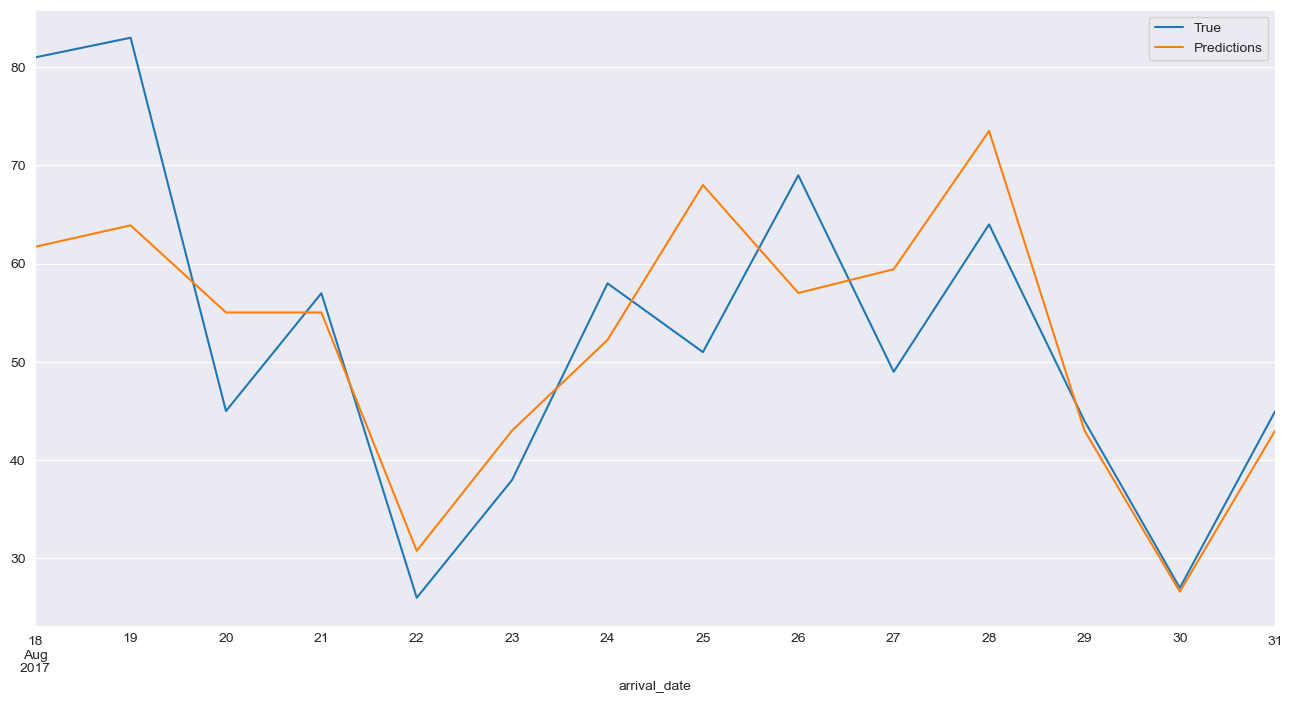

In [603]:
ax = time_data_by_day_2.loc[(time_data_by_day_2.index >= time_test_2.index[0]) &
                            (time_data_by_day_2.index <= time_test_2.index[-1])]['is_canceled'].plot(figsize=(16,8))
time_data_by_day_2.loc[(time_data_by_day_2.index >= time_test_2.index[0]) &
                       (time_data_by_day_2.index <= time_test_2.index[-1])]['prediction_2'].plot(ax = ax)
plt.legend(['True', 'Predictions'])
plt.show()

In [369]:
time_data_by_day.head()

,is_canceled,total_bookings,prediction_x,prediction_y,prediction_x,prediction_y,prediction,prediction_2
arrival_date,,,,,,,,
2015-07-01,19,122,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,57,93,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,19,56,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-04,43,88,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-05,16,53,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

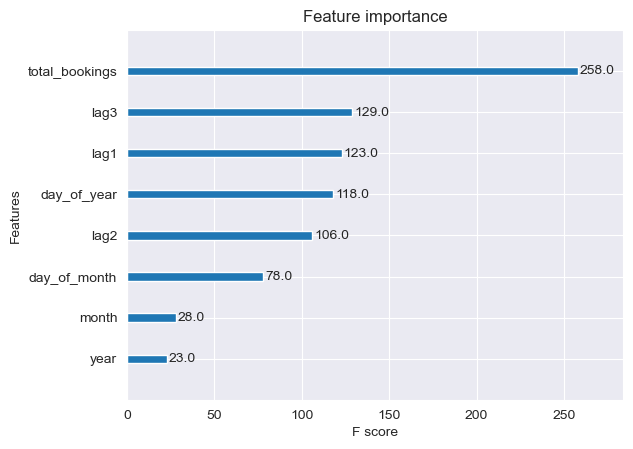

In [604]:
from xgboost import plot_tree, plot_importance
plot_importance(best_model)

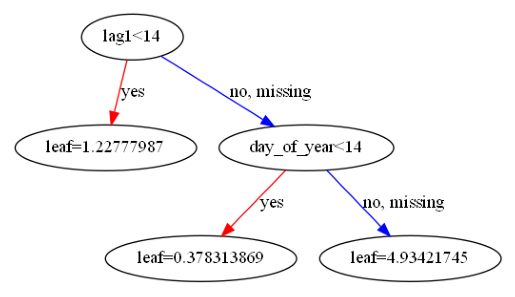

In [605]:
plot_tree(best_model); plt.show()

In [443]:
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9927286837432157, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.7464693554236559, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.14689850783126918, max_bin=428,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=1.9623507734573744, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=5, ...)


In [607]:
time_data_smax = time_data_by_day_2.drop(columns='prediction_2')
time_data_smax.head()

,is_canceled,total_bookings,lag1,lag2,lag3
arrival_date,,,,,
2015-07-01,19,122,0.0,0.0,0.0
2015-07-02,57,93,0.0,0.0,0.0
2015-07-03,19,56,0.0,0.0,0.0
2015-07-04,43,88,0.0,0.0,0.0
2015-07-05,16,53,0.0,0.0,0.0


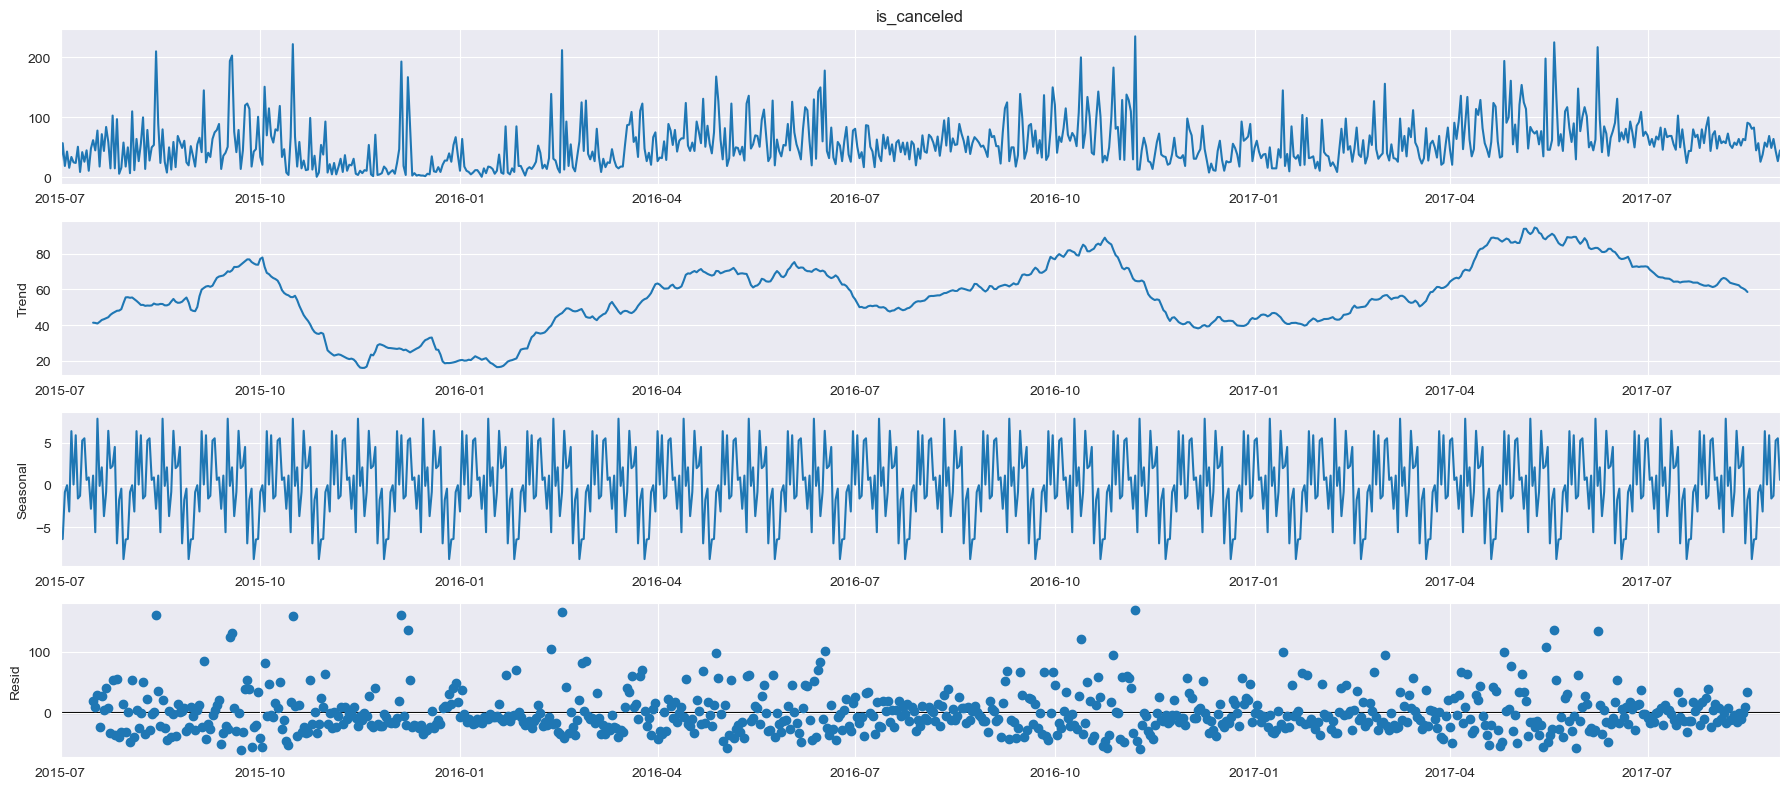

In [611]:
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(time_data_smax['is_canceled'], model = 'additive', period=30)
fig = decomposition.plot()
plt.show()

In [655]:
train_smax = time_data_smax.is_canceled[:-100]
train_smax.head()

arrival_date
2015-07-01    19
2015-07-02    57
2015-07-03    19
2015-07-04    43
2015-07-05    16
Name: is_canceled, dtype: int64

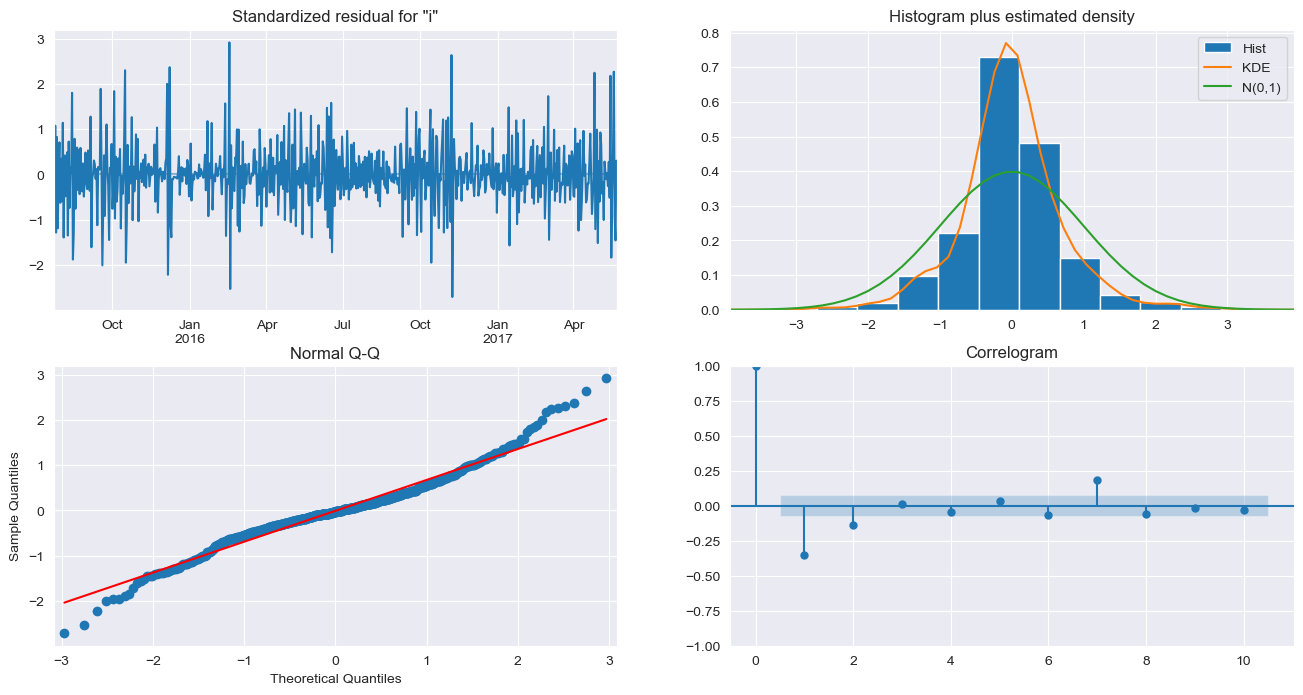

In [656]:
mod = sm.tsa.statespace.SARIMAX(train_smax,
                                order=(1, 4, 5),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model1 = mod.fit()

model1.plot_diagnostics(figsize=(16, 8))
plt.show()

In [652]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          is_canceled   No. Observations:                  693
Model:             SARIMAX(1, 4, 5)x(1, 0, [1], 12)   Log Likelihood               -3641.541
Date:                              Fri, 17 Mar 2023   AIC                           7301.083
Time:                                      05:36:51   BIC                           7341.662
Sample:                                  07-01-2015   HQIC                          7316.800
                                       - 05-23-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8052      0.331     -2.429      0.015      -1.455      -0.156
ma.L1         -2.3144      0.349     -6.640      0.000      -2.998      -1.631
ma.L2          0.9244      1.067      0.867      0.386      -1.166       3.015
ma.L3          1.1610      1.208      0.961      0.337      -1.207       3.529
ma.L4         -0.8289      0.586     -1.415      0.157      -1.977       0.319
ma.L5          0.0580      0.116      0.499      0.618      -0.170       0.286
ar.S.L12       0.0996      0.854      0.117      0.907      -1.574       1.774
ma.S.L12      -0.0538      0.861     -0.063      0.950      -1.741       1.633
sigma2      5019.6325    498.756     10.064      0.000    4042.089    5997.177
===================================================================================
Ljung-Box (L1) (Q):                  83.01   Jarque-Bera (JB):               135.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.19
Prob(H) (two-sided):                  0.46   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [658]:
results = model1.predict(100)

TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

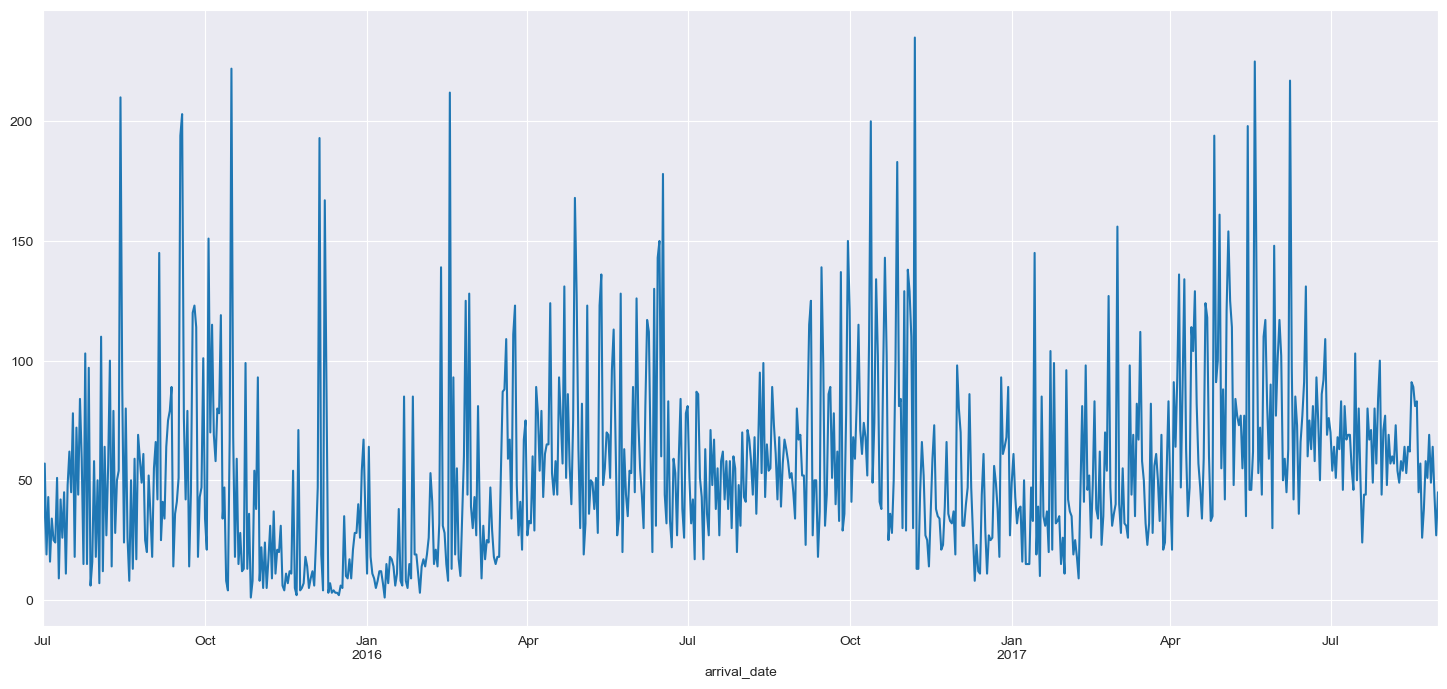

In [659]:
start_forecast = 693
pred = model1.get_prediction(start=start_forecast, dynamic=False)
pred_ci = pred.conf_int()

ax = time_data_smax.is_canceled.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predictions', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Cancellations')
plt.legend()

plt.show()


In [673]:
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
from sklearn import metrics
warnings.filterwarnings("ignore")

In [674]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true,y_pred)}')
    print(f'MSE is : {metrics.mean_absolute_error(y_true,y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [675]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [681]:
for name, column in time_data_smax[['is_canceled' ,'total_bookings']].iteritems():
    Augmented_Dickey_Fuller_Test_func(time_data_smax[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: is_canceled
Test Statistic                  -2.586275
p-value                          0.095867
No Lags Used                    20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
dtype: float64
Test Statistic                  -2.586275
p-value                          0.095867
No Lags Used                    20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
Critical Value (5%)             -2.865291
dtype: float64
Test Statistic                  -2.586275
p-value                          0.095867
No Lags Used                    20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
Critical Value (5%)             -2.865291
Critical Value (10%)            -2.568767
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: total_bookings
Test Statis

In [679]:
X = time_data_smax[['is_canceled' ]]
actualtrain, actualtest = X[0:-30], X[-30:]
exoX = time_data_smax[['total_bookings' ]]
exotrain, exotest = exoX[0:-30], exoX[-30:]

In [685]:
for m in [7]:
    print("="*100)
    print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
    stepwise_model = auto_arima(actualtrain,exogenous =exotrain ,
                                start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True,
                                start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7,m=m, d=None,D=None,
                                trace=True,error_action='ignore',suppress_warnings=True,
                                stepwise=True)
    print(f'Model summary for m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()
    forecast,conf_int = stepwise_model.predict(n_periods=30, exogenous =exotest,return_conf_int=True)
    df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound', 'Lower_bound'])
    timeseries_evaluation_metrics_func(actualtest, forecast)

 Fitting SARIMAX for Seasonal value m = 7
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8090.958, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7899.510, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7641.982, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8088.960, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=7658.594, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=7593.292, Time=0.78 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=7640.049, Time=0.23 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=7643.027, Time=1.21 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=7639.092, Time=0.54 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=5.81 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=8037.042, Time=0.33 sec
 ARIMA(0,1,

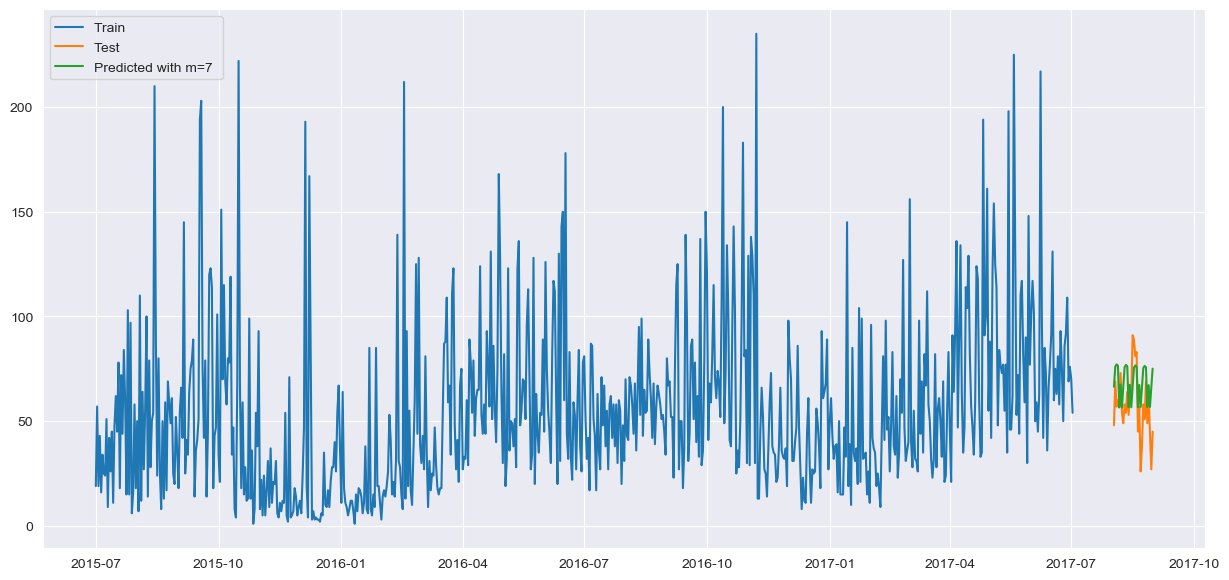

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 7


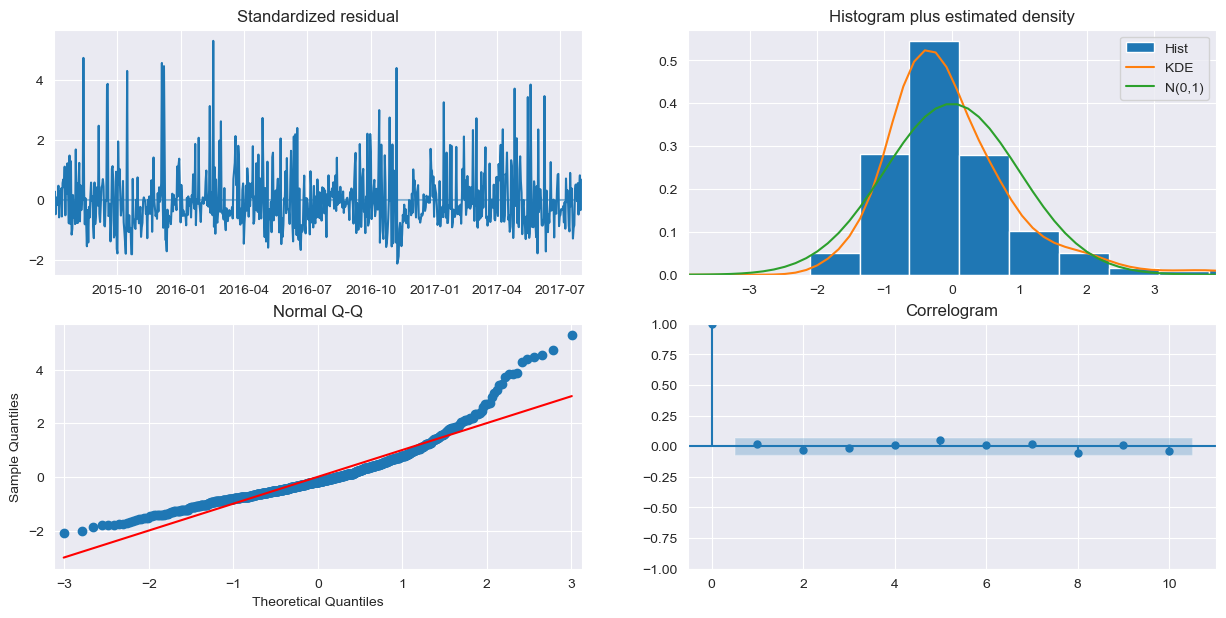

----------------------------------------------------------------------------------------------------


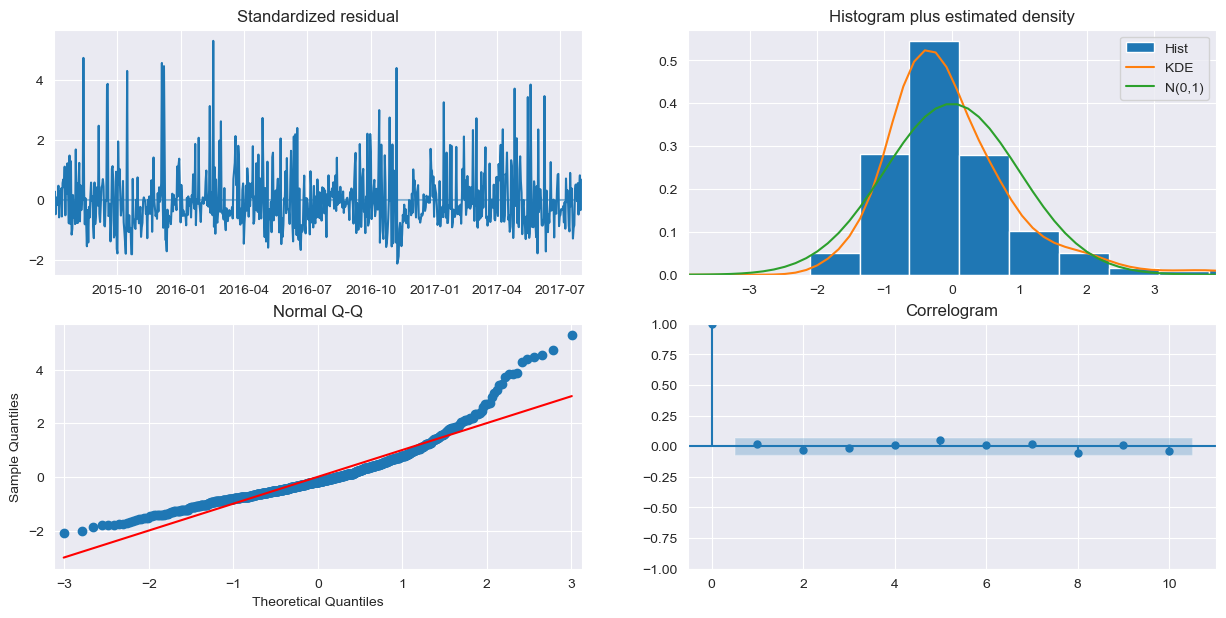

In [687]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15, 7]
plt.plot(actualtrain.is_canceled[:-30], label='Train ')
plt.plot(actualtest, label='Test ')
plt.plot(forecast, label=f'Predicted with m={str(m)} ')
plt.legend(loc='best')
plt.show()
print("-"*100)
print(f' Diagnostic plot for Seasonal value m = {str(m)}')
display(stepwise_model.plot_diagnostics());
print("-"*100)

In [691]:
data.loc[:,'arrival_date'] = data.apply(lambda x: year_format(x['arrival_date_year'], x['arrival_date_month'],
                                                                        x['arrival_date_day_of_month']), axis=1)
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0.0,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015,1/July/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0.0,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015,1/July/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0.0,0.0,0,Transient,75.0,0,0,Check-Out,2/7/2015,1/July/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2/7/2015,1/July/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,0.0,0,Transient,98.0,0,1,Check-Out,3/7/2015,1/July/2015


In [692]:
data['arrival_date'] = pd.to_datetime(data.arrival_date)

In [742]:
time_data_mv = data.groupby('arrival_date')['is_canceled'].sum()
time_data_mv.head()

arrival_date
2015-07-01    19
2015-07-02    57
2015-07-03    19
2015-07-04    43
2015-07-05    16
Name: is_canceled, dtype: int64

In [747]:
time_data_mv = pd.concat([time_data_mv, data['arrival_date'].value_counts(), data.groupby('arrival_date')[[
    'stays_in_week_nights', 'stays_in_weekend_nights', 'adr', 'lead_time']].aggregate(['mean'])], axis = 1)
time_data_mv.head()

,is_canceled,arrival_date,"(stays_in_week_nights, mean)","(stays_in_weekend_nights, mean)","(adr, mean)","(lead_time, mean)"
2015-07-01,19,122,2.745902,0.368852,92.828934,186.745902
2015-07-02,57,93,3.129032,0.806452,82.205484,153.129032
2015-07-03,19,56,3.339286,0.946429,97.183036,72.857143
2015-07-04,43,88,3.125000,1.863636,85.582273,154.965909
2015-07-05,16,53,3.679245,2.283019,100.002642,83.641509


In [748]:
time_data_mv = create_feature(time_data_mv)

In [749]:
time_data_mv.head()

,is_canceled,arrival_date,"(stays_in_week_nights, mean)","(stays_in_weekend_nights, mean)","(adr, mean)","(lead_time, mean)",day_of_month,month,year,day_of_year
2015-07-01,19,122,2.745902,0.368852,92.828934,186.745902,1,7,2015,182
2015-07-02,57,93,3.129032,0.806452,82.205484,153.129032,2,7,2015,183
2015-07-03,19,56,3.339286,0.946429,97.183036,72.857143,3,7,2015,184
2015-07-04,43,88,3.125000,1.863636,85.582273,154.965909,4,7,2015,185
2015-07-05,16,53,3.679245,2.283019,100.002642,83.641509,5,7,2015,186


In [763]:
time_data_mv = create_lag(time_data_mv, 'is_canceled', 14)
time_data_mv.head()

,is_canceled,arrival_date,"(stays_in_week_nights, mean)","(stays_in_weekend_nights, mean)","(adr, mean)","(lead_time, mean)",day_of_month,month,year,day_of_year,lag1,lag2,lag3
2015-07-01,19,122,2.745902,0.368852,92.828934,186.745902,1,7,2015,182,0.0,0.0,0.0
2015-07-02,57,93,3.129032,0.806452,82.205484,153.129032,2,7,2015,183,0.0,0.0,0.0
2015-07-03,19,56,3.339286,0.946429,97.183036,72.857143,3,7,2015,184,0.0,0.0,0.0
2015-07-04,43,88,3.125000,1.863636,85.582273,154.965909,4,7,2015,185,0.0,0.0,0.0
2015-07-05,16,53,3.679245,2.283019,100.002642,83.641509,5,7,2015,186,0.0,0.0,0.0


In [764]:
time_data_mv.fillna(0)
time_data_mv.head()

,is_canceled,arrival_date,"(stays_in_week_nights, mean)","(stays_in_weekend_nights, mean)","(adr, mean)","(lead_time, mean)",day_of_month,month,year,day_of_year,lag1,lag2,lag3
2015-07-01,19,122,2.745902,0.368852,92.828934,186.745902,1,7,2015,182,0.0,0.0,0.0
2015-07-02,57,93,3.129032,0.806452,82.205484,153.129032,2,7,2015,183,0.0,0.0,0.0
2015-07-03,19,56,3.339286,0.946429,97.183036,72.857143,3,7,2015,184,0.0,0.0,0.0
2015-07-04,43,88,3.125000,1.863636,85.582273,154.965909,4,7,2015,185,0.0,0.0,0.0
2015-07-05,16,53,3.679245,2.283019,100.002642,83.641509,5,7,2015,186,0.0,0.0,0.0


In [807]:
time_data_mv.columns

Index([                      'is_canceled',
                            'arrival_date',
          ('stays_in_week_nights', 'mean'),
       ('stays_in_weekend_nights', 'mean'),
                           ('adr', 'mean'),
                     ('lead_time', 'mean'),
                            'day_of_month',
                                   'month',
                                    'year',
                             'day_of_year',
                                    'lag1',
                                    'lag2',
                                    'lag3'],
      dtype='object')

In [811]:
# rename columns
time_data_mv = time_data_mv.rename({('stays_in_week_nights', 'mean'): 'mean_week_stay',
                     ("stays_in_weekend_nights", "mean"): 'mean_weekend_stay',
                     ("adr", "mean"): 'mean_adr',
                     ("lead_time", "mean"): 'mean_lead_time'
                     }, axis=1, errors='raise')

In [812]:
time_data_mv.head()

,is_canceled,arrival_date,mean_week_stay,mean_weekend_stay,mean_adr,mean_lead_time,day_of_month,month,year,day_of_year,lag1,lag2,lag3
2015-07-01,19,122,2.745902,0.368852,92.828934,186.745902,1,7,2015,182,0.0,0.0,0.0
2015-07-02,57,93,3.129032,0.806452,82.205484,153.129032,2,7,2015,183,0.0,0.0,0.0
2015-07-03,19,56,3.339286,0.946429,97.183036,72.857143,3,7,2015,184,0.0,0.0,0.0
2015-07-04,43,88,3.125000,1.863636,85.582273,154.965909,4,7,2015,185,0.0,0.0,0.0
2015-07-05,16,53,3.679245,2.283019,100.002642,83.641509,5,7,2015,186,0.0,0.0,0.0


In [816]:
# outlier detection
def find_outlier(col):
    '''
    :param col: an np.array_like object or a dataframe column for which outliers are to be detected
        :type: np.array/pd.DataFrame
    :return: upper and lower outlier limits
    '''
    q1 = np.quantile(col, 0.25)
    q3 = np.quantile(col, 0.75)
    iqr = q3-q1
    upper_outlier = q3 + 1.5*iqr
    lower_outlier = q1 - 1.5*iqr
    return upper_outlier, lower_outlier

In [824]:
import statistics

In [855]:
def replace_outliers(df: pd.DataFrame):
    '''
    :param df: dataframe object with outliers in columns
    :return:
    '''
    for col in df.columns:
        ul, ll = find_outlier(df[f'{col}'])
        median_low = statistics.median_low(df[f'{col}'])
        median_high= statistics.median_high(df[f'{col}'])
        mean = np.mean(df[f'{col}'])
        rep_val = (median_high + median_low + mean)/3
        def replace_fn(x):
            x = rep_val if x > ul or x < ll or x < 0 else x
        df[f'{col}'].apply(replace_fn)
    return df

In [856]:
time_data_mv = replace_outliers(time_data_mv)
time_data_mv.head()

,is_canceled,arrival_date,mean_week_stay,mean_weekend_stay,mean_adr,mean_lead_time,day_of_month,month,year,day_of_year,lag1,lag2,lag3
2015-07-01,19,122,2.745902,0.368852,92.828934,186.745902,1,7,2015,182,0.0,0.0,0.0
2015-07-02,57,93,3.129032,0.806452,82.205484,153.129032,2,7,2015,183,0.0,0.0,0.0
2015-07-03,19,56,3.339286,0.946429,97.183036,72.857143,3,7,2015,184,0.0,0.0,0.0
2015-07-04,43,88,3.125000,1.863636,85.582273,154.965909,4,7,2015,185,0.0,0.0,0.0
2015-07-05,16,53,3.679245,2.283019,100.002642,83.641509,5,7,2015,186,0.0,0.0,0.0


In [864]:
features_mv = [_ for _ in time_data_mv.columns]
features_mv.remove('is_canceled')
print(features_mv)

['arrival_date', 'mean_week_stay', 'mean_weekend_stay', 'mean_adr', 'mean_lead_time', 'day_of_month', 'month', 'year', 'day_of_year', 'lag1', 'lag2', 'lag3']


In [858]:
features_mv.remove('mean_week_stay')
features_mv.remove('mean_weekend_stay')
print(features_mv)

['arrival_date', 'mean_adr', 'mean_lead_time', 'day_of_month', 'month', 'year', 'day_of_year', 'lag1', 'lag2', 'lag3']


In [865]:
X_train_mv, X_test_mv = time_data_mv.iloc[:-14][features_mv],time_data_mv.iloc[-14:][features_mv]
y_train_mv, y_test_mv = time_data_mv.iloc[:-14][target],time_data_mv.iloc[-14:][target]

In [860]:
def hyperparameter_tuning_mv(space: dict):
    model = xgb.XGBRegressor(**space)

    #Define evaluation datasets.
    evaluation = [(X_train_mv, y_train_mv), (X_test_mv, y_test_mv)]
    evaluation_dart = [(X_test_mv, y_test_mv)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train_mv, y_train_mv, eval_set = evaluation, verbose = False)
    #Obtain prediction and log_loss score.
    pred = model.predict(X_test_mv)
    loss = mape(y_test_mv, pred)
    print ("SCORE:", loss)

    #Specify what the loss is for each model.
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [861]:
space_mv = {'max_depth': scope.int(hp.quniform("max_depth", 1, 15, 1)),
         'max_leaves': scope.int(hp.quniform("max_leaves", 1, 50, 1)),
         'gamma': hp.uniform ('gamma', 0,1),
         'reg_alpha' : hp.uniform('reg_alpha', 0,50),
         'reg_lambda' : hp.uniform('reg_lambda', 10,200),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
         'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
         'n_estimators': 10000,
         'learning_rate': hp.uniform('learning_rate', 0, .1),
         'tree_method':'gpu_hist',
         'gpu_id': 0,
         'random_state': 7,
         'max_bin' : scope.int(hp.quniform('max_bin', 200, 650, 1)),
         'sampling_method': 'gradient_based',
         'eval_metric': 'mape',
         'early_stopping_rounds': 10,
            'booster': 'dart',
            'sample_type': 'weighted',
            'normalize_type': 'forest',
            'rate_drop': hp.uniform('rate_drop', 0, 1),
            'skip_drop': hp.uniform('skip_drop', 0, 1),
         }

In [862]:
trials = Trials()
best_mv = fmin(fn=hyperparameter_tuning_mv,
               space=space_mv,
               algo=tpe.suggest,
               max_evals=30,
               trials=trials)

print(best_mv)

SCORE:                                                
0.33279560107000405                                   
SCORE:                                                                           
0.278298344890879                                                                
SCORE:                                                                           
0.33552454144610305                                                            
SCORE:                                                                         
0.2770514133241325                                                             
SCORE:                                                                          
0.31122892211122166                                                             
 17%|█▋        | 5/30 [00:36<03:03,  7.32s/trial, best loss: 0.2770514133241325]


KeyboardInterrupt: 

In [784]:
best_model_mv = trials.results[np.argmin([r['loss'] for r in
                                       trials.results])]['model']

#Examine model hyperparameters
print(best_model_mv)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8413492268750052, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.6434842134384395, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.007898202441845593, max_bin=644,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=40,
             min_child_weight=1.4003842409674938, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=7, ...)


In [874]:
name_map = {'arrival_date' : 'arrival_date',
            "('stays_in_week_nights', 'mean')": 'mean_week_stay',
            "('stays_in_weekend_nights', 'mean')": 'mean_weekend_stay',
            "('adr', 'mean')": 'mean_adr',
            "('lead_time', 'mean')": 'mean_lead_time',
            'day_of_month' : 'day_of_month',
            'month' : 'month',
            'year':'year',
            'day_of_year':'day_of_year',
            'lag1':'lag1',
            'lag2':'lag2',
            'lag3':'lag3'
            }
new_feature_name = [name_map[name] for name in best_model_mv.get_booster().feature_names]

In [877]:
booster = best_model_mv.get_booster()
booster.feature_names = new_feature_name

In [878]:
booster.save_model('./model1_renamed')

In [879]:
model = xgb.XGBRegressor()
model.load_model('./model1_renamed')

In [880]:
mape(y_test_mv, model.predict(X_test_mv))

0.3889374078731781

In [884]:
pred_set = pd.DataFrame(model.predict(X_test_mv))

In [887]:
pred_set.index = time_data_by_day_2.index[-14:]

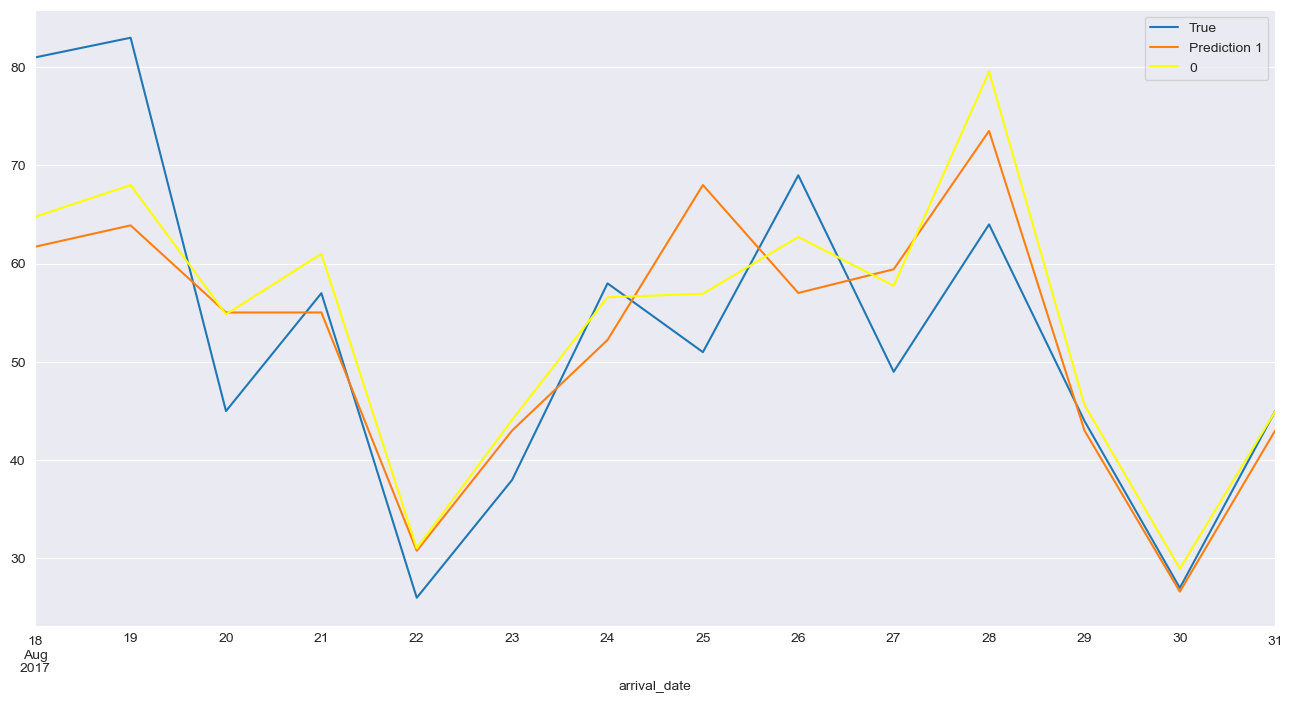

In [899]:
ax = time_data_by_day_2.loc[(time_data_by_day_2.index >= time_test_2.index[0]) &
                            (time_data_by_day_2.index <= time_test_2.index[-1])]['is_canceled'].plot(figsize=(16,8), label = 'True')
time_data_by_day_2.loc[(time_data_by_day_2.index >= time_test_2.index[0]) &
                            (time_data_by_day_2.index <= time_test_2.index[-1])]['prediction_2'].plot(ax = ax, label = 'Prediction 1')

pred_set.plot(ax = ax, color = 'yellow', label = 'Prediction 2')
plt.legend()
plt.show()

In [902]:
data_set_stack = pd.DataFrame(np.column_stack([best_model.predict(X_test), model.predict(X_test_mv)]))
data_set_stack.index = time_data_mv.index[-14:]
data_set_stack['True'] = time_data_mv.is_canceled[-14:]
data_set_stack.head()

,0,1,True
2017-08-18,61.729519,64.778893,81
2017-08-19,63.901554,68.001335,83
2017-08-20,55.036037,54.846291,45
2017-08-21,55.036037,61.007961,57
2017-08-22,30.776442,31.028610,26


In [913]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100000, random_state=12)
rf.fit(data_set_stack[[0,1]][:10], y = data_set_stack['True'][:10])

RandomForestRegressor(n_estimators=100000, random_state=12)

In [914]:
last_4 = rf.predict(data_set_stack[[0,1]][10:])
last_4

array([80.48546, 42.41532, 31.57867, 42.41532])

In [911]:
data_set_stack.iloc[10:]

,0,1,True
2017-08-28,73.513031,79.542770,64
2017-08-29,43.026463,45.626945,44
2017-08-30,26.618547,28.959629,27
2017-08-31,43.026463,44.964085,45


In [718]:
avg_adr = data.groupby('arrival_date')['adr'].mean()
avg_adr.head()

arrival_date
2015-07-01     92.828934
2015-07-02     82.205484
2015-07-03     97.183036
2015-07-04     85.582273
2015-07-05    100.002642
Name: adr, dtype: float64

In [719]:
avg_lead = data.groupby('arrival_date')['lead_time'].mean()
avg_lead.head()

arrival_date
2015-07-01    186.745902
2015-07-02    153.129032
2015-07-03     72.857143
2015-07-04    154.965909
2015-07-05     83.641509
Name: lead_time, dtype: float64

NameError: name 'avg_lead' is not defined